In [1]:
#Load packages
import pandas as pd
import numpy as np

# I. Comparing Event Run Values

In [2]:
# Read in MLBAM Data for 2014-2017

MLBAM14 = pd.read_csv("../Data/MLBAM14.csv")
MLBAM15 = pd.read_csv("../Data/MLBAM15.csv")
MLBAM16 = pd.read_csv("../Data/MLBAM16.csv")
MLBAM17 = pd.read_csv("../Data/MLBAM17.csv")
MLBAM17.head()

,Unnamed: 0,inning,batterId,pitcherId,event,x,y,ab_num,timestamp,stand,...,fielderId,gameId,isPA,isAB,isHit,isBIP,our.x,our.y,r,theta
0,1,1,458731,502042,Flyout,65.59,123.50,1,2017-04-02 17:12:18,L,...,605480.0,gid_2017_04_02_nyamlb_tbamlb_1,True,True,False,True,-148.267814,188.423160,239.763700,2.237490
1,2,1,596142,502042,Groundout,128.19,193.88,2,2017-04-02 17:15:42,R,...,502042.0,gid_2017_04_02_nyamlb_tbamlb_1,True,True,False,True,7.961190,12.777835,15.055020,1.013603
2,3,1,595885,502042,Walk,NaN,NaN,3,2017-04-02 17:16:48,L,...,NaN,gid_2017_04_02_nyamlb_tbamlb_1,True,False,False,False,NaN,NaN,NaN,NaN
3,4,1,407812,502042,Groundout,153.48,157.29,4,2017-04-02 17:19:09,R,...,543543.0,gid_2017_04_02_nyamlb_tbamlb_1,True,True,False,True,71.076710,104.094437,126.045827,0.971701
4,5,1,572816,547888,Single,140.75,73.31,5,2017-04-02 17:24:43,L,...,NaN,gid_2017_04_02_nyamlb_tbamlb_1,True,True,True,True,39.306818,313.680887,316.134030,1.446138


In [3]:
# Using a function similar to what was used in the week’s exercise notebook,
# calculate the run value for every event in 2014, 2015, 2016 and 2017.

def Run_Expectancy(path):
    
    RE = pd.read_csv(path)
    RE.drop(['Unnamed: 0'], axis=1, inplace=True)
    RE = RE[['home_team','away_team','half','gameId','batterName','batterId','event', 'start1B', 'start2B', 'start3B',\
             'end1B', 'end2B', 'end3B', 'startOuts','endOuts','runsFuture','runsOnPlay','outsInInning','venueId','batterPos']]
    RE['Start1'] = np.where(pd.isnull(RE['start1B']),0,1)
    RE['Start2'] = np.where(pd.isnull(RE['start2B']),0,1)
    RE['Start3'] = np.where(pd.isnull(RE['start3B']),0,1)
    RE['Start_State'] = (RE['Start1'].astype(str) + RE['Start2'].astype(str) + RE['Start3'].astype(str)+\
                          " " + RE['startOuts'].astype(str))
    RE['End1'] = np.where(pd.isnull(RE['end1B']),0,1)
    RE['End2'] = np.where(pd.isnull(RE['end2B']),0,1)
    RE['End3'] = np.where(pd.isnull(RE['end3B']),0,1)
    RE['End_State'] = (RE['End1'].astype(str) + RE['End2'].astype(str) + RE['End3'].astype(str) + \
                        " " + RE['endOuts'].astype(str))
    RE = RE[((RE.Start_State != RE.End_State) | (RE.runsOnPlay > 0)) & (RE.outsInInning == 3)]
    Start_RunExp = RE.groupby(['Start_State'])['runsFuture'].mean().reset_index().rename(columns={'runsFuture':'Start_RE'})
    RE = pd.merge(RE, Start_RunExp, on=['Start_State'], how='left')
    Base_State_3 = [pd.Series(['000 3', 0], index=Start_RunExp.columns),
                pd.Series(['001 3', 0], index=Start_RunExp.columns),
                pd.Series(['010 3', 0], index=Start_RunExp.columns),
                pd.Series(['011 3', 0], index=Start_RunExp.columns),
                pd.Series(['100 3', 0], index=Start_RunExp.columns),
                pd.Series(['101 3', 0], index=Start_RunExp.columns),
                pd.Series(['110 3', 0], index=Start_RunExp.columns),
                pd.Series(['111 3', 0], index=Start_RunExp.columns)]
    Start_RunExp = Start_RunExp.append(Base_State_3, ignore_index=True)
    End_RunExp  = Start_RunExp.rename(columns={'Start_State':'End_State', 'Start_RE':'End_RE'})
    RE = pd.merge(RE, End_RunExp, on=['End_State'], how='left')
    RE['Run_Value'] = RE['runsOnPlay'] + RE['End_RE'] - RE['Start_RE']
    
    return RE;

In [15]:
# Calculate the average run value for each type of event for every season
RE_14 = Run_Expectancy("../Data/MLBAM14.csv")      
RE_15 = Run_Expectancy("../Data/MLBAM15.csv")      
RE_16 = Run_Expectancy("../Data/MLBAM16.csv")      
RE_17 = Run_Expectancy("../Data/MLBAM17.csv")      

Event_Value14 = RE_14.groupby(['event'])['Run_Value'].mean().reset_index().rename(columns = {"Run_Value": 'RV14'})
Event_Value15 = RE_15.groupby(['event'])['Run_Value'].mean().reset_index().rename(columns = {"Run_Value": 'RV15'})
Event_Value16 = RE_16.groupby(['event'])['Run_Value'].mean().reset_index().rename(columns = {"Run_Value": 'RV16'})
Event_Value17 = RE_17.groupby(['event'])['Run_Value'].mean().reset_index().rename(columns = {"Run_Value": 'RV17'})

In [16]:
# Merge the event level run values for each season into one data frame.
# The data frame should include the event name and then four columns with the run values (one for each season).

RVseasons = pd.merge(Event_Value14,Event_Value15, on = ['event'])
RVseasons = pd.merge(RVseasons,Event_Value16, on = ['event'])
RVseasons = pd.merge(RVseasons,Event_Value17, on = ['event'])

In [17]:
# Delete the row for event “Sacrifice Bunt DP”

RVseasons = RVseasons[RVseasons['event']!="Sacrifice Bunt DP"]

In [18]:
# Compute the correlation matrix for event level run values across all seasons
RVseasons.corr()

,RV14,RV15,RV16,RV17
RV14,1.000000,0.998819,0.997951,0.997153
RV15,0.998819,1.000000,0.997570,0.996412
RV16,0.997951,0.997570,1.000000,0.994964
RV17,0.997153,0.996412,0.994964,1.000000


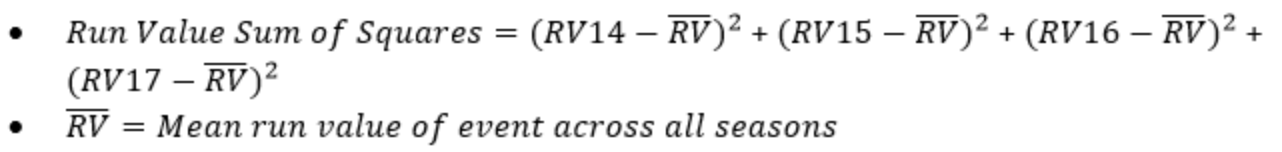

In [22]:
# For each event, calculate the sum of squares between run values using the data 
# from all four seasons and create a column for this sum of squares variable
RVseasons["RV_all_season"] = (RVseasons["RV14"] + RVseasons["RV15"] + RVseasons["RV16"] + RVseasons["RV17"])/4
RVseasons["RV_Sum_Sq"] = (RVseasons["RV14"]-RVseasons["RV_all_season"])**2 + (RVseasons["RV15"]-RVseasons["RV_all_season"])**2 \
                        + (RVseasons["RV16"]-RVseasons["RV_all_season"])**2 + (RVseasons["RV17"]-RVseasons["RV_all_season"])**2

Question 1
Which two seasons have the strongest correlation between run values?

Question 2
Which event has the highest sum of squares value?

In [26]:
RVseasons[RVseasons["RV_Sum_Sq"] == RVseasons["RV_Sum_Sq"].max()]

,event,RV14,RV15,RV16,RV17,RV_all_season,RV_Sum_Sq
28,Triple Play,-1.608127,-1.688951,-1.637543,-1.471223,-1.601461,0.025963


Question 3
What was the average run value of a “Flyout” in 2014?

In [29]:
RVseasons[RVseasons["event"] == "Flyout"]

,event,RV14,RV15,RV16,RV17,RV_all_season,RV_Sum_Sq
11,Flyout,-0.229247,-0.240853,-0.247896,-0.262548,-0.245136,0.000582


# II. Comparing Player Run Values

In [30]:
# Compute the aggregate player level run values for each season
Player_Value14 = RE_14.groupby(['batterId','batterName'])['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV14'})
Player_Value15 = RE_15.groupby(['batterId','batterName'])['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV15'})
Player_Value16 = RE_16.groupby(['batterId','batterName'])['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV16'})
Player_Value17 = RE_17.groupby(['batterId','batterName'])['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV17'})

In [31]:
# Merge player run values for each season into one data frame so that only players with run values
# for all four seasons are included in the data frame.
# The data frame should include each player’s name and then four columns with the run values (one for each season).
Player_Value = pd.merge(Player_Value14, Player_Value15, on = ['batterId','batterName'])
Player_Value = pd.merge(Player_Value, Player_Value16, on = ['batterId','batterName'])
Player_Value = pd.merge(Player_Value, Player_Value17, on = ['batterId','batterName'])

In [32]:
# Compute the correlation matrix for event level run values across all seasons
Player_Value.corr()

,batterId,RV14,RV15,RV16,RV17
batterId,1.000000,-0.144210,-0.003344,-0.056668,0.091117
RV14,-0.144210,1.000000,0.466299,0.426629,0.322764
RV15,-0.003344,0.466299,1.000000,0.546136,0.510132
RV16,-0.056668,0.426629,0.546136,1.000000,0.457391
RV17,0.091117,0.322764,0.510132,0.457391,1.000000


In [33]:
# Run a regression model by regressing player run values from 2017 (dependent variable)
# on player run values from 2014, 2015, and 2016 (independent variables)
import statsmodels.formula.api as smf

lm = smf.ols(formula='RV17 ~ RV14 + RV15 + RV16', data = Player_Value).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RV17   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     54.61
Date:                Wed, 22 May 2024   Prob (F-statistic):           3.20e-29
Time:                        22:20:53   Log-Likelihood:                -1458.4
No. Observations:                 372   AIC:                             2925.
Df Residuals:                     368   BIC:                             2941.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0472      0.650      0.073      0.942      -1.231       1.326
RV14           0.0620      0.056      1.101      0.272      -0.049       0.173
RV15           0.3509      0.054      6.480      0.000       0.244       0.457
RV16           0.2673      0.059      4.532      0.000       0.151       0.383
==============================================================================
Omnibus:                       39.399   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.833
Skew:                           0.548   Prob(JB):                     3.11e-20
Kurtosis:                       5.144   Cond. No.                         20.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Question 1
What was the correlation in player run values between 2014 and 2016?

Question 2
What is the R-squared for the regression model run in step 4?

Question 3
What is the regression coefficient of RV15 when used as an independent variable in the regression?

# III. Comparing Team Run Values

In [34]:
# For each season’s run expectancy data frame, create a variable “team” to denote the batting team

# Since each event is identified as occurring at the top of the inning (away team) or bottom of the inning (home team),
#we can use this variable to associate each event with the offensive record of the batter's team.
RE_14['team']= np.where(RE_14['half']=='top',RE_14['away_team'],RE_14['home_team'])
RE_15['team']= np.where(RE_15['half']=='top',RE_15['away_team'],RE_15['home_team'])
RE_16['team']= np.where(RE_16['half']=='top',RE_16['away_team'],RE_16['home_team'])
RE_17['team']= np.where(RE_17['half']=='top',RE_17['away_team'],RE_17['home_team'])


In [35]:
# Compute the aggregate team level run values for each season

REteam_14= RE_14.groupby(['team'])['Run_Value'].sum().reset_index().rename(columns= {"Run_Value": 'RV14'})
REteam_15= RE_15.groupby(['team'])['Run_Value'].sum().reset_index().rename(columns= {"Run_Value": 'RV15'})
REteam_16= RE_16.groupby(['team'])['Run_Value'].sum().reset_index().rename(columns= {"Run_Value": 'RV16'})
REteam_17= RE_17.groupby(['team'])['Run_Value'].sum().reset_index().rename(columns= {"Run_Value": 'RV17'})

In [36]:
# Merge team run values for each season into one data frame. The data frame should include each team’s name and then four columns with the run values (one for each season).

RV_Team = pd.merge(REteam_14, REteam_15, on = "team")
RV_Team = pd.merge(RV_Team, REteam_16, on = "team")
RV_Team = pd.merge(RV_Team, REteam_17, on = "team")

In [37]:
# Compute the correlation matrix for event level run values across all seasons
RV_Team.corr()

,RV14,RV15,RV16,RV17
RV14,1.000000,0.363681,0.261814,0.065225
RV15,0.363681,1.000000,0.437610,0.193061
RV16,0.261814,0.437610,1.000000,0.351708
RV17,0.065225,0.193061,0.351708,1.000000


In [39]:
# Run a regression model by regressing team run values from 2017 (dependent variable) on team run values from 2014, 2015, and 2016 (independent variables)

lm = smf.ols(formula='RV17 ~ RV14 + RV15 + RV16', data = RV_Team).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RV17   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.265
Date:                Wed, 22 May 2024   Prob (F-statistic):              0.307
Time:                        23:07:37   Log-Likelihood:                -166.93
No. Observations:                  30   AIC:                             341.9
Df Residuals:                      26   BIC:                             347.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4437     12.406     -0.036      0.972     -25.944      25.056
RV14          -0.0553      0.241     -0.230      0.820      -0.550       0.440
RV15           0.0706      0.240      0.294      0.771      -0.424       0.565
RV16           0.3788      0.231      1.638      0.113      -0.097       0.854
==============================================================================
Omnibus:                        0.584   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.747   Jarque-Bera (JB):                0.061
Skew:                           0.065   Prob(JB):                        0.970
Kurtosis:                       3.179   Cond. No.                         77.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Question 1
What was the correlation in team run values between 2014 and 2017?

Question 2
What is the R-squared for the regression model run in step 5?

Question 3
What is the regression coefficient of RV16 when used as an independent variable in the regression?

Question 4
Which independent variable(s) had coefficients that were significant in the player level regression but insignificant in the team level regression (at the .05 significance level)?